In [ ]:
import pandas as pd
import numpy as np


In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
data = pd.read_csv("/content/AirPassengers.csv")

In [ ]:
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [ ]:
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')  # Adjust format as necessary
data.set_index('Month', inplace=True)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [ ]:
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
print(data.isnull().sum())


Passengers    0
dtype: int64


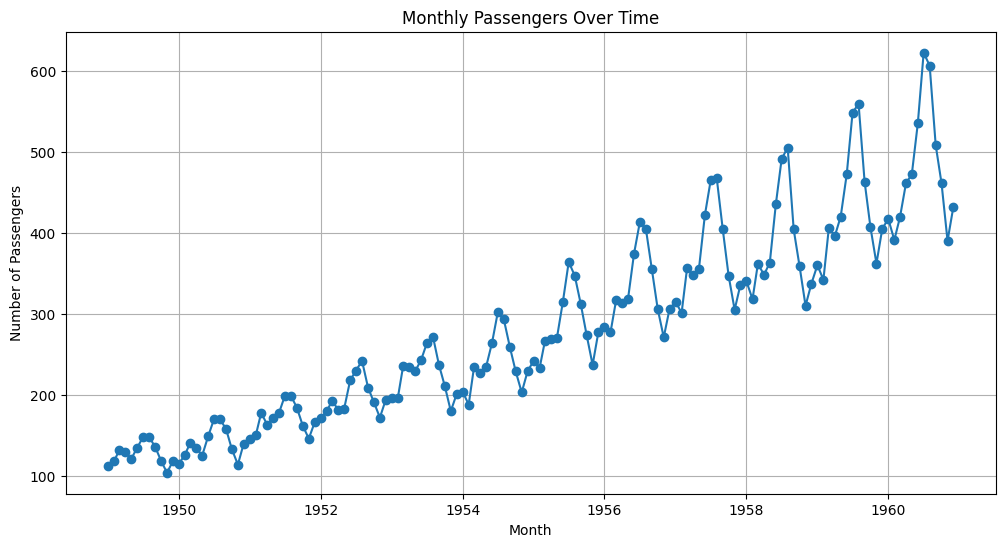

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'], marker='o')
plt.title('Monthly Passengers Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.grid()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data['Passengers'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641


In [ ]:
#Here P-Value is greater than 0.05 hence the series is not stationary

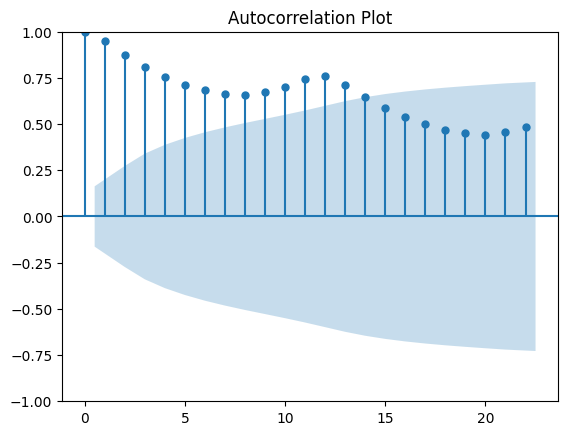

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data['Passengers'])
plt.title('Autocorrelation Plot')
plt.show()


In [ ]:
#peak after every 12 lags data is seasonal.

In [ ]:
data['Passengers_diff'] = data['Passengers'].diff().dropna()


In [ ]:
result_diff = adfuller(data['Passengers_diff'].dropna())
print('ADF Statistic (Differenced):', result_diff[0])
print('p-value (Differenced):', result_diff[1])


ADF Statistic (Differenced): -2.8292668241700047
p-value (Differenced): 0.05421329028382478


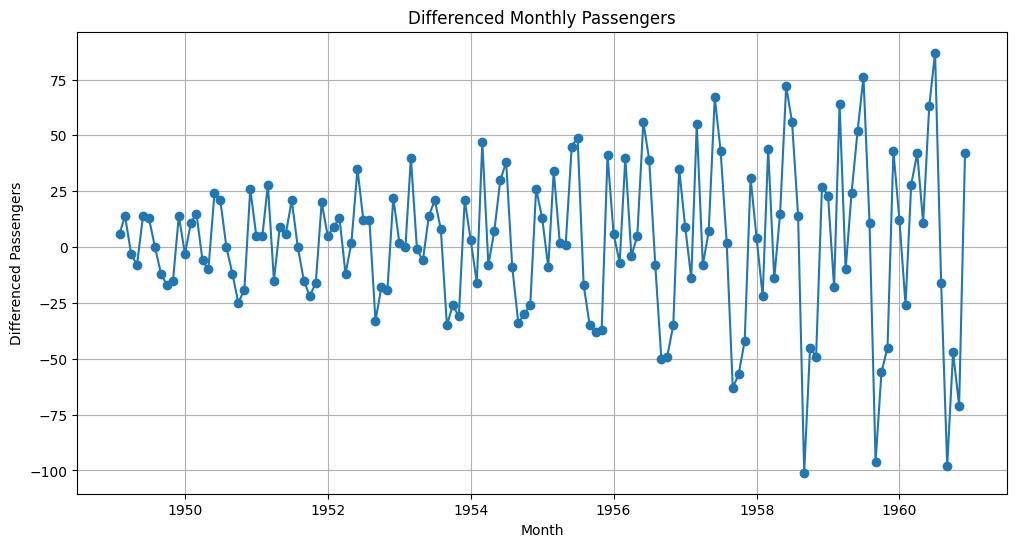

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['Passengers_diff'], marker='o')
plt.title('Differenced Monthly Passengers')
plt.xlabel('Month')
plt.ylabel('Differenced Passengers')
plt.grid()
plt.show()


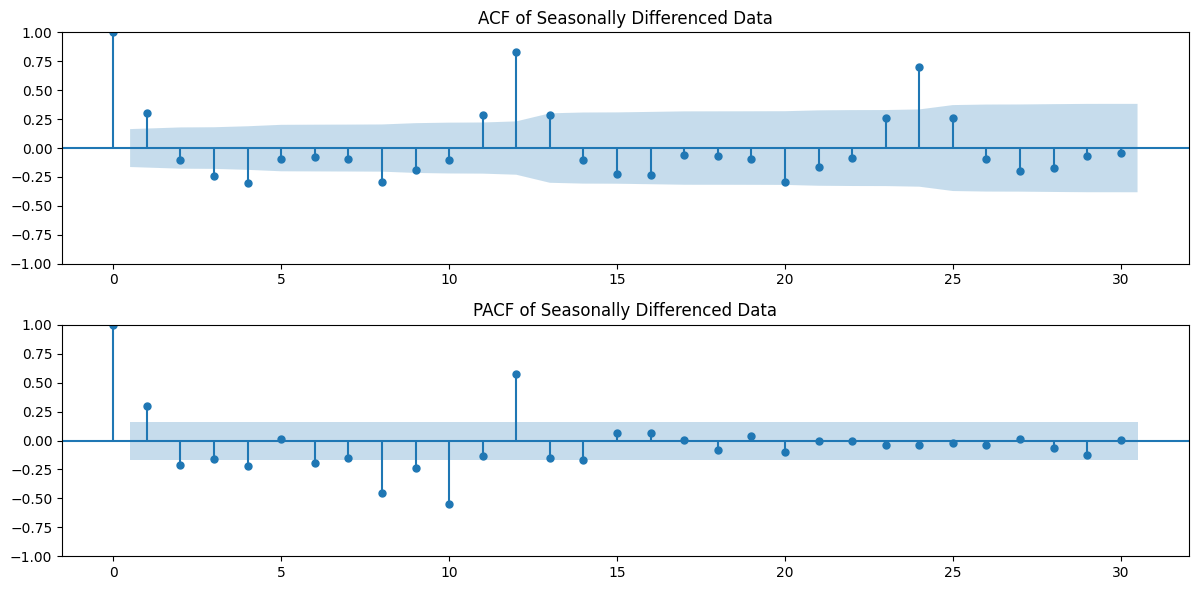

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the seasonally differenced data
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(data['Passengers_diff'].dropna(), lags=30, ax=plt.gca())
plt.title('ACF of Seasonally Differenced Data')

plt.subplot(212)
plot_pacf(data['Passengers_diff'].dropna(), lags=30, ax=plt.gca())
plt.title('PACF of Seasonally Differenced Data')

plt.tight_layout()
plt.show()


In [ ]:
# The results of the Augmented Dickey-Fuller (ADF) test after differencing show an ADF statistic of approximately
# -2.829 and a p-value of about 0.054. This indicates that the difference data is close to being stationary,
# but the p-value is still slightly above the common significance level of 0.05. This means that while there
# is some evidence to suggest stationarity, it is not conclusive.

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model
model = SARIMAX(data['Passengers'], order=(1, 1, 2), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)
print(model_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(1, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -506.061
Date:                              Thu, 28 Nov 2024   AIC                           1024.121
Time:                                      17:58:46   BIC                           1041.373
Sample:                                  01-01-1949   HQIC                          1031.131
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4124      1.496     -0.276      0.783      -3.344       2.519
ma.L1          0.06

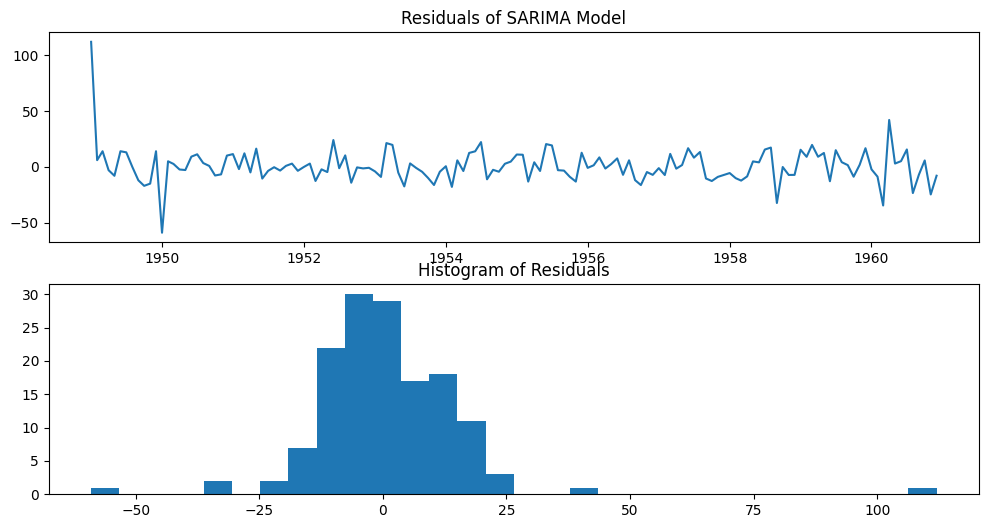

ADF Statistic (Residuals): -14.798015965026938
p-value (Residuals): 2.120760725258886e-27


In [ ]:
residuals = model_fit.resid

plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals of SARIMA Model')

plt.subplot(212)
plt.hist(residuals, bins=30)
plt.title('Histogram of Residuals')
plt.show()

# Perform ADF test on residuals
result_residuals = adfuller(residuals)
print('ADF Statistic (Residuals):', result_residuals[0])
print('p-value (Residuals):', result_residuals[1])


<ipython-input-58-21bc21499c0f>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')


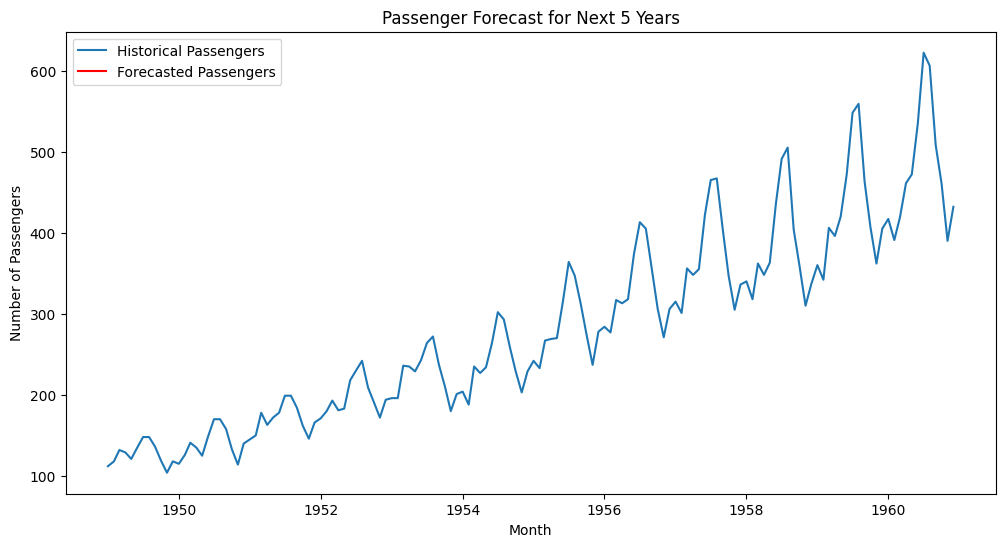

In [ ]:
forecast_steps = 60  # Forecast for the next 5 years (monthly)
forecast = model_fit.forecast(steps=forecast_steps)

# Create a new DataFrame for the forecast
forecast_index = pd.date_range(start=data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='M')
forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['Forecasted Passengers'])

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(data['Passengers'], label='Historical Passengers')
plt.plot(forecast_df, label='Forecasted Passengers', color='red')
plt.title('Passenger Forecast for Next 5 Years')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()
